# Noise Contrastive Estimation to Calculate Absolute Free Energies

In [1]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
import pickle
import scipy.integrate as integrate
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.set_default_dtype(torch.double)

### Define Potential Energy Function

In [106]:
def compute_Muller_potential(beta, x): #x must be type tensor
    A = (-200., -100., -170., 15.)
    b = (0., 0., 11., 0.6)    
    ac = (x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-6.5, -6.5]),
          x.new_tensor([0.7, 0.7]))
    
    x0 = (x.new_tensor([ 1.0, 0.0]),
          x.new_tensor([ 0.0, 0.5]),
          x.new_tensor([-0.5, 1.5]),
          x.new_tensor([-1.0, 1.0]))
    
    U = 0    
    for i in range(4):
        diff = x - x0[i]
        U = U + A[i]*torch.exp(torch.sum(ac[i]*diff**2, -1) + b[i]*torch.prod(diff, -1))
    
    size = x.size()
    result = beta*U
    return torch.reshape(result, (size[0], 1))

### Define Model

In [193]:
class NCE(nn.Module):
    def __init__(self):
        super(NCE, self).__init__()
        self.U_x = nn.Sequential(
          nn.Linear(2, 20),
          nn.Tanh(),
          nn.Linear(20, 30),
          nn.Tanh(),
          nn.Linear(30, 10),
          nn.Tanh(),
          nn.Linear(10, 1),
        )
        self.beta = 0.05 
        self.muller_energy = compute_Muller_potential

    def forward(self, x):
        #return -self.beta*self.U_x(x) 
        return -self.beta*self.U_x(x) #-self.muller_energy(self.beta, x)
        
    def ln_p_m(self, x): 
        #return -self.beta*self.U_x(x) 
        return -self.beta*self.U_x(x) #-self.muller_energy(self.beta, x) 
    
    def ln_p_n(self, noise_samples, noise_beta):
        return -self.muller_energy(noise_beta, noise_samples) - 10
    
    def G_x_theta(self, x, noise_beta):
        return self.ln_p_m(x) - self.ln_p_n(x, noise_beta)

    def h_x_theta(self, x, noise_beta):
        return torch.sigmoid(self.G_x_theta(x, noise_beta))
    
    def loss(self, X_true, Y_true, noise_beta=0.05): #Y_true is a huge misnomer. Y_true is X_noise.
        T = X_true.size()[0] + Y_true.size()[0]
        J_T_vec = torch.log(self.h_x_theta(X_true, noise_beta)) + torch.log(1 - self.h_x_theta(Y_true, noise_beta)).to(device)
        return -(1/(2*T))*torch.sum(J_T_vec)

### Load Data and Create Basin1 and Basin2 Dataset

In [195]:
#bounds of the total area, but this is kind of meaningless
#x1_min, x1_max = -1.5, 1; x2_min, x2_max = -0.5, 2.0
Abounds = [[-1.5, 0], [0.55, 2]] #basin 1 bounds. So -1.5 < x < 0, 0.55 < y < 2.
Bbounds = [[-0.8, 1], [-0.5, 0.8]] #basin 2 bounds. So -0.8 < x < 1, -0.5 < y < 0.8.

d = os.path.abspath('')
beta = 0.05

with open('Asamples_beta_{:.3f}.pkl'.format(beta), 'rb') as file_handle:
    dataA = pickle.load(file_handle)
xsamplesA = dataA['x_record']
betasA = dataA['beta_lst']

with open('Bsamples_beta_{:.3f}.pkl'.format(beta), 'rb') as file_handle:
    dataB = pickle.load(file_handle)
xsamplesB = dataB['x_record']
betasB = dataB['beta_lst']

betas = betasA
data_dictionaryA = dict()
data_dictionaryB = dict()

counter = 0
for beta in betasA:
    data_dictionaryA[float(beta)] = xsamplesA[:, counter, :]
    data_dictionaryB[float(beta)] = xsamplesB[:, counter, :]
    counter = counter + 1

List of defined betas: [0.0010, 0.0064, 0.0119, 0.0173, 0.0228, 0.0282, 0.0337, 0.0391, 0.0446, 0.0500].

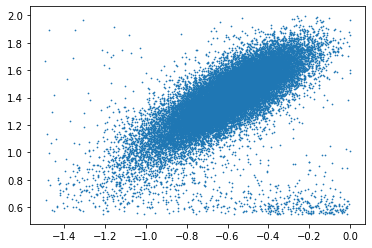

In [196]:
samplesA = torch.tensor(data_dictionaryA[0.05])[0:]
samplesB = torch.tensor(data_dictionaryB[0.05])[0:]
plt.scatter(samplesA[:, 0], samplesA[:, 1], s = 0.5)

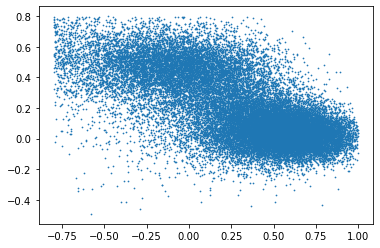

In [197]:
plt.scatter(samplesB[:, 0], samplesB[:, 1], s=0.5)

### Train Model on Region A

In [198]:
def train_helper(model, optimizer, noise_samples, true_samples, bnoise):
    model.train()
    train_loss = 0

    optimizer.zero_grad()
    loss = model.loss(true_samples, noise_samples, bnoise)
    loss.backward()

    train_loss += loss.item()
    optimizer.step()

def train_main(model, optimizer, betas, data_dictionary, truebeta):
    true_samples = torch.tensor(data_dictionary[btrue]).to(device)
    for epoch in range(0, 10-4, 1):
        for beta_index in range(0+epoch, 9-4, 1):
            
            noise_beta = float(betas[beta_index])
            #print(noise_beta)

            batchsize= 150 #150
            if noise_beta < 0.05: 
                noise_samples = torch.tensor(data_dictionary[noise_beta]).to(device)
            
                for index in range(0, 200, 1):
                    train_helper(model, optimizer, noise_samples[index*150:(index+1)*150], 
                        true_samples[index*batchsize:(index+1)*batchsize], noise_beta)

btrue = 0.05
device = torch.device("cpu")

modelA = NCE().to(device)
optimizerA = optim.Adam(modelA.parameters(), lr=0.5*1e-3)
train_main(modelA, optimizerA, betas, data_dictionaryA, 0.05)

modelB = NCE().to(device)
optimizerB = optim.Adam(modelB.parameters(), lr=0.5*1e-3)
train_main(modelB, optimizerB, betas, data_dictionaryB, 0.05)

### DeepFEP

The free energy difference should be: -28.46.

In [224]:
def E_A(samples):
    return (modelA(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()

def E_B(samples):
    return (modelB(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()

num_samples = 200

samplesA = torch.tensor(data_dictionaryA[0.05])
samplesB = torch.tensor(data_dictionaryB[0.05])

subsamplesA = torch.tensor(data_dictionaryA[0.05][0:num_samples, :])
subsamplesB = torch.tensor(data_dictionaryB[0.05][0:num_samples, :])

U_0_A = np.reshape(np.array(compute_Muller_potential(0.05, subsamplesA)), (num_samples,1))
U_0_B = np.reshape(np.array(compute_Muller_potential(0.05, subsamplesB)), (num_samples,1))

F_A = (1/beta)*np.log(np.average(np.exp( E_A(subsamplesA) - U_0_A )))

#the values above already have beta multiplied into them 
B_avg = np.average(np.exp( E_B(subsamplesB) - U_0_B ))

F_B = (1/beta)*np.log(B_avg)

print(F_A) #should be 103
print(F_B) #should be 74
print(F_A - F_B)

tensor(112.3802)
tensor(67.6444)
tensor(44.7358)


<ipython-input-224-f4db350ff7cd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelA(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()
<ipython-input-224-f4db350ff7cd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelB(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()


<ipython-input-224-f4db350ff7cd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelB(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()


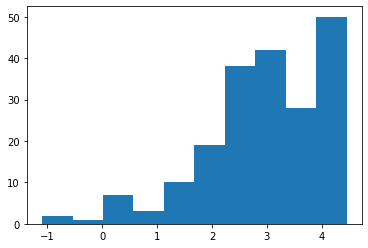

In [225]:
plt.hist(E_B(subsamplesB) - U_0_B) #this should be absolute F_A, which is
plt.show()

<ipython-input-224-f4db350ff7cd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelA(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()


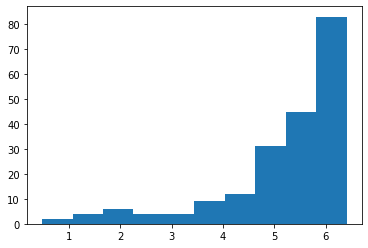

In [226]:
plt.hist(E_A(subsamplesA) - U_0_A)
plt.show()

### Picture Contour Plot of Energy

In [227]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, ndim1, ndim2):
    x1 = torch.linspace(x1_min, x1_max, steps=ndim1)
    x2 = torch.linspace(x2_min, x2_max, steps=ndim2)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2)
    grid = torch.stack([grid_x1, grid_x2], dim = -1)
    x = grid.reshape((-1, 2))
    return x
    
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0
ndim = 100

x = generate_grid(x1_min, x1_max, x2_min, x2_max, ndim, ndim)
U = E_A(x)
U = U.reshape(ndim, ndim)
U = U.T

<ipython-input-224-f4db350ff7cd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelA(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()


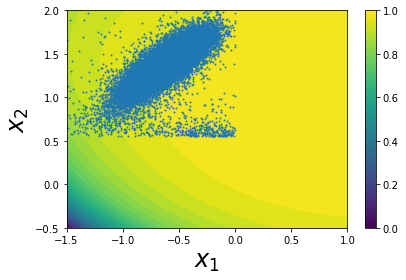

In [231]:
fig = plt.figure(0)
fig.clf()
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
#plt.contourf(U, levels = 30, cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.scatter(samplesA[:, 0], samplesA[:, 1], s=0.9)
plt.colorbar()
plt.tight_layout()

<ipython-input-224-f4db350ff7cd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (modelB(torch.tensor(samples).reshape(len(samples), 2).to(device))).cpu().detach().numpy()


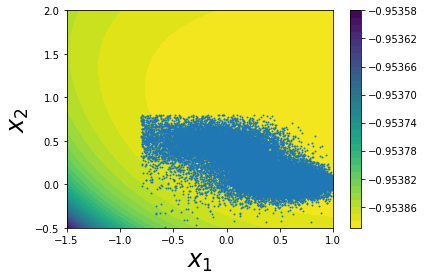

In [229]:
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0
ndim = 100

x = generate_grid(x1_min, x1_max, x2_min, x2_max, ndim, ndim)
U = E_B(x)
U = U.reshape(ndim, ndim)
U = U.T

fig = plt.figure(0)
fig.clf()
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
#plt.contourf(U, levels = 30, cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.colorbar()
plt.scatter(samplesB[:, 0], samplesB[:, 1], s=0.9)
plt.tight_layout()